## Demo

In [16]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
import json
import random
import pickle

from ultralytics import YOLO
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from matplotlib import pyplot as plt
from demo_libs import preprocess_video, loadFrameFromVideoPath, find_path_from_id, getOpticalFlow, pred_mp_frames, calculateOpticalFlowTvl1, baseline_model_i3d_flow, baseline_model_i3d, baseline_model_stgcn, augment_i3d, augment_stgcn

In [17]:
face_landmarker_path = "./models/yolov11n-face.pt"
yolov11_detection_path = "./models/yolo11n.pt"
pose_estimation_path = "./models/yolo11n-pose.pt"
hand_landmarker_path = "./models/hand_landmarker.task"
pose_landmarker_path = "./models/pose_landmarker_heavy.task"

glossary_path = "./glossary.json"
labelEncoder_path = "./label_encoder.pkl"
data_splitting_path = "./data_splitting.json"
dataset_dir = "./data"

output_rgb_dir = "./data-preprocess/rgb"
output_optical_flow_farneback_dir = "./data-preprocess/optical_flow_farneback"
output_optical_flow_tvl1_dir = "./data-preprocess/optical_flow_tvl1"
output_pose_dir = "./data-preprocess/pose"
output_base_dir = "./data-preprocess"

rgb_dataset_dir = "./data-preprocess/rgb/"
farneback_dataset_dir = "./data-preprocess/optical_flow_farneback/"
tvl1_dataset_dir = "./data-preprocess/optical_flow_tvl1/"
skeleton_dataset_dir = "./data-preprocess/pose/"

model_output_dir = "./output-models"

rgb_model_path = "./output-models/rgb_model.keras"
farneback_model_path = "./output-models/farneback_model.keras"
tvl1_model_path = "./output-models/tvl1_model.keras"
skeleton_model_path = "./output-models/skeleton_model.keras"

rgb_model_history_path = "./output-models/rgb_model_history.csv"
farneback_model_history_path = "./output-models/farneback_model_history.csv"
tvl1_model_history_path = "./output-models/tvl1_model_history.csv"
skeleton_model_history_path = "./output-models/skeleton_model_history.csv"

In [18]:
# for person and face recognition, we use yolov11
yolo_person_estimation_model = YOLO(yolov11_detection_path)
yolo_face_estimation_model = YOLO(face_landmarker_path)

# for joint recognition, we use pose_landmarker from mediapipe
pose_base_options = python.BaseOptions(model_asset_path=pose_landmarker_path)
pose_options = vision.PoseLandmarkerOptions(base_options=pose_base_options, num_poses=1)
pose_predictor = vision.PoseLandmarker.create_from_options(pose_options)

# for hand joint recognition, we use hand_landmarker from mediapipe
hand_base_options = python.BaseOptions(model_asset_path=hand_landmarker_path)
hand_options = vision.HandLandmarkerOptions(base_options=hand_base_options, num_hands=2)
hand_predictor = vision.HandLandmarker.create_from_options(hand_options)

In [19]:
# loads glossary
with open(glossary_path, "r") as f:
    dicts = json.load(f)

# loads label encoder
with open(labelEncoder_path, "rb") as f:
    label_encoder = pickle.load(f)

# loads data splitting
with open(data_splitting_path, "r") as f:
    data_splitting = json.load(f)

c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.7.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [20]:
# loads a random sample from the test dataset
X_train = np.array(data_splitting["train"]["listId"])
y_train = np.array(data_splitting["train"]["labels"])

In [21]:
random_index = random.randint(0, len(X_train) - 1)
sample_id = X_train[random_index]
sample_label = y_train[random_index]
sample_label_name = label_encoder.inverse_transform([sample_label])[0]

# load frame
sample_frame_path = find_path_from_id(dataset_dir, sample_id)
if sample_frame_path is None:
    raise FileNotFoundError(f"File with id {sample_id} not found in dataset directory.")

# load video
print(f"Loading video from path: {sample_frame_path}")
print("Loading frames...")
frames = loadFrameFromVideoPath(sample_frame_path)
print("get bounding boxes...")
frames_preprocessed = preprocess_video(sample_frame_path, yolo_person_estimation_model)
print("Calculating TVL1 optical flow...")
frames_tvl1 = calculateOpticalFlowTvl1(frames_preprocessed)
print("Calculating Farneback optical flow...")
frames_farneback = getOpticalFlow(frames_preprocessed)
print("Calculating pose landmarks...")
pose_landmarks = pred_mp_frames(pose_predictor, hand_predictor, frames_preprocessed)

Loading video from path: ./data\Kata Lainnya\Dan\BISINDO_Kata Lainnya_Dan_6.mov
Loading frames...
get bounding boxes...
Calculating TVL1 optical flow...
Calculating Farneback optical flow...
Calculating pose landmarks...


(-0.5, 255.5, 255.5, -0.5)

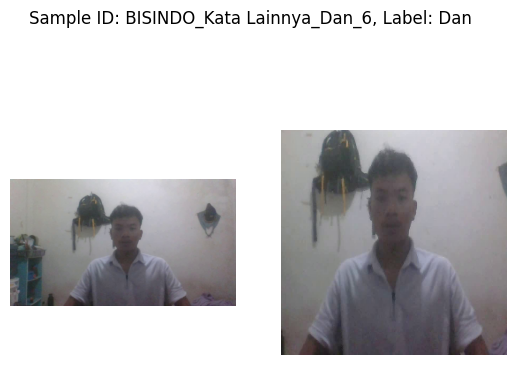

In [22]:
plt.subplot(1, 2, 1)
plt.suptitle(f"Sample ID: {sample_id}, Label: {sample_label_name}")
plt.imshow(frames[0])
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(frames_preprocessed[0])
plt.axis('off')

In [23]:
farneback_model = baseline_model_i3d_flow(50)
tvl1_model = baseline_model_i3d_flow(50)
skeleton_model = baseline_model_stgcn(50)
rgb_model = baseline_model_i3d(50)

# load pretrained models
farneback_model.load_weights(farneback_model_path)
tvl1_model.load_weights(tvl1_model_path)
skeleton_model.load_weights(skeleton_model_path)
rgb_model.load_weights(rgb_model_path)

c:\Users\Lenovo\Documents\codes\pythons\machine learning\skripsi\new_skripsi\Data\i3d_inception.py:98: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 2 input channels.
  warnings.warn(
c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 234 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 186 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [24]:
augmented_frames_farneback = augment_i3d(frames_farneback, dim=(64, 224, 224, 2), normalize=False, padding_technique="zero")
augmented_frames_tvl1 = augment_i3d(frames_tvl1, dim=(64, 224, 224, 2), normalize=False, padding_technique="zero")
augmented_frames_rgb = augment_i3d(frames)
augmented_pose_landmarks = augment_stgcn(pose_landmarks)

In [25]:
rgb_prediction = rgb_model.predict(augmented_frames_rgb)
farneback_prediction = farneback_model.predict(augmented_frames_farneback)
tvl1_prediction = tvl1_model.predict(augmented_frames_tvl1)
skeleton_prediction = skeleton_model.predict(augmented_pose_landmarks)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 36s 36s/step


Top 5 predictions:
1. Dan - score: -0.8176
2. Malam - score: -0.9225
3. Marah - score: -1.0699
4. Sekian - score: -1.1322
5. Teman - score: -1.3213


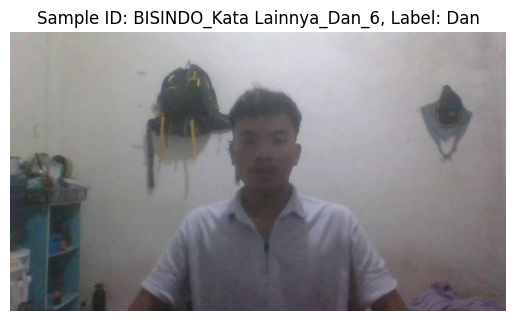

In [42]:
combination_preds = [rgb_prediction, farneback_prediction, skeleton_prediction]
combination_preds = np.array(combination_preds)
combination_preds = np.mean(combination_preds, axis=0)

# display top 5 predictions
top_5_indices = np.argsort(combination_preds[0])[::-1][:5]
top_5_labels = [label_encoder.inverse_transform([i])[0] for i in top_5_indices]
print("Top 5 predictions:")
for i, label in enumerate(top_5_labels):
    print(f"{i + 1}. {label} - score: {combination_preds[0][top_5_indices[i]]:.4f}")

plt.imshow(frames[0])
plt.title(f"Sample ID: {sample_id}, Label: {sample_label_name}")
plt.axis('off')
plt.show()